# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD:
- Normalized graph of nominal features (Sahra)
- Delay date computation (Sahra)
- Preprocessing & one-hot encoding (Benny)
- Predictpy.sec function (Benny)
- Explain reasoning behind disregarded columns
- General Explanations: Plots, Feature importance, ...
- Powerpoint slides
- Export of objects of interest for presentation: Graphs, Tables, ...
- Feature list for Partial Dependence Plots

</font>

### Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. \
 This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. \
  One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. \
   However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. \
   Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. \
    On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

### Task 

The task at hand involves **constructing a predictive model** that leverages various features associated with a customer’s initial order. \
 The objective is to **determine whether a €5.00 voucher should be issued to a specific customer**. Detailed descriptions of these features can be found in the data dictionary.pdf file. \
The model should be **designed to predict if a customer will place a subsequent order within a 90-day period** following their initial purchase. This information is represented by the target90 variable in the dataset. \
 The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. \
  It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [35]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import joblib # to save trained model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import shap # SHAP values for local interpretability
from sklearn.inspection import permutation_importance # permutation feature importance for global interpretability
from sklearn.inspection import PartialDependenceDisplay as pdp # partial dependence plots for global interpretability
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import plot_tree
from lime import lime_tabular # Local interpretable model agonstic explanations
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [20]:
# Separator is ;
data = pd.read_csv("train.csv", sep = ";")

# Set seed for reproducibility
seed = 1

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.


In [21]:
print(data['invoicepostcode'].unique())
print(len(data['invoicepostcode'].unique()))

[58 34 51 25 41 95 78 77 86 97 50 40 99 85 88 17 70 30 68 15 12 63 18 89
 49 20 42 21 73 22 55 23  7 65 79 57 46 27 10 52 66 91 24 74 61 56 76 38
 26 32 39 84 29 33  1 16 13 80  2 14 45 81 53 90 60  3 64 54 71 28 36 67
 44 31 47 35  9  4 69 59 92 93 37 48 94 96 72 83 75  8 82  6 87 19 98 11
  0]
97


---

### Visualization of feature distribution

In [22]:
# Gather caterogical and continuous features in separate lists
cat_features = ["salutation", "title", "domain", "newsletter", "model", "paymenttype", "deliverytype",
                     "voucher", "case", "gift", "entry", "points", "shippingcosts", "invoicepostcode"] # target90
cntnous_features = ["numberitems", "weight", "remi", "cancel", "used", "w0", "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10"]

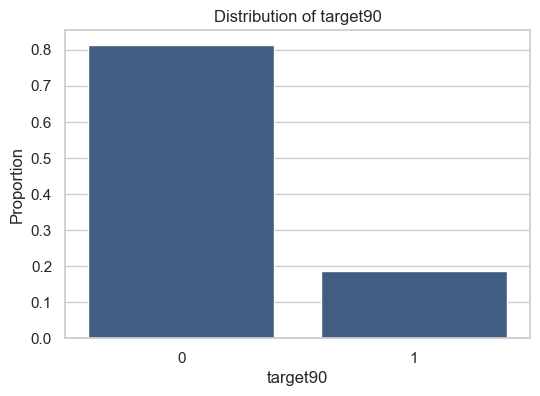

Only 18.66% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.


In [23]:
# Draw distribution of target90 variable in data
plt.figure(figsize=(6, 4))

# Count the occurrences of target category
counts = data['target90'].value_counts(normalize=True).reset_index(name='count')

# Plot the count plot
sns.barplot(x='target90', y='count', data=counts, color="#365c8d")

plt.title(f"Distribution of target90")
plt.xlabel('target90')
plt.ylabel('Proportion')
plt.show()

print(f"Only {np.round(data['target90'].mean()*100,2)}% of customers in the data set repurchased in the next 90 days. This makes the data set imbalanced and we have to proceed with caution.")

- Distribution of nominal features with respect to target90

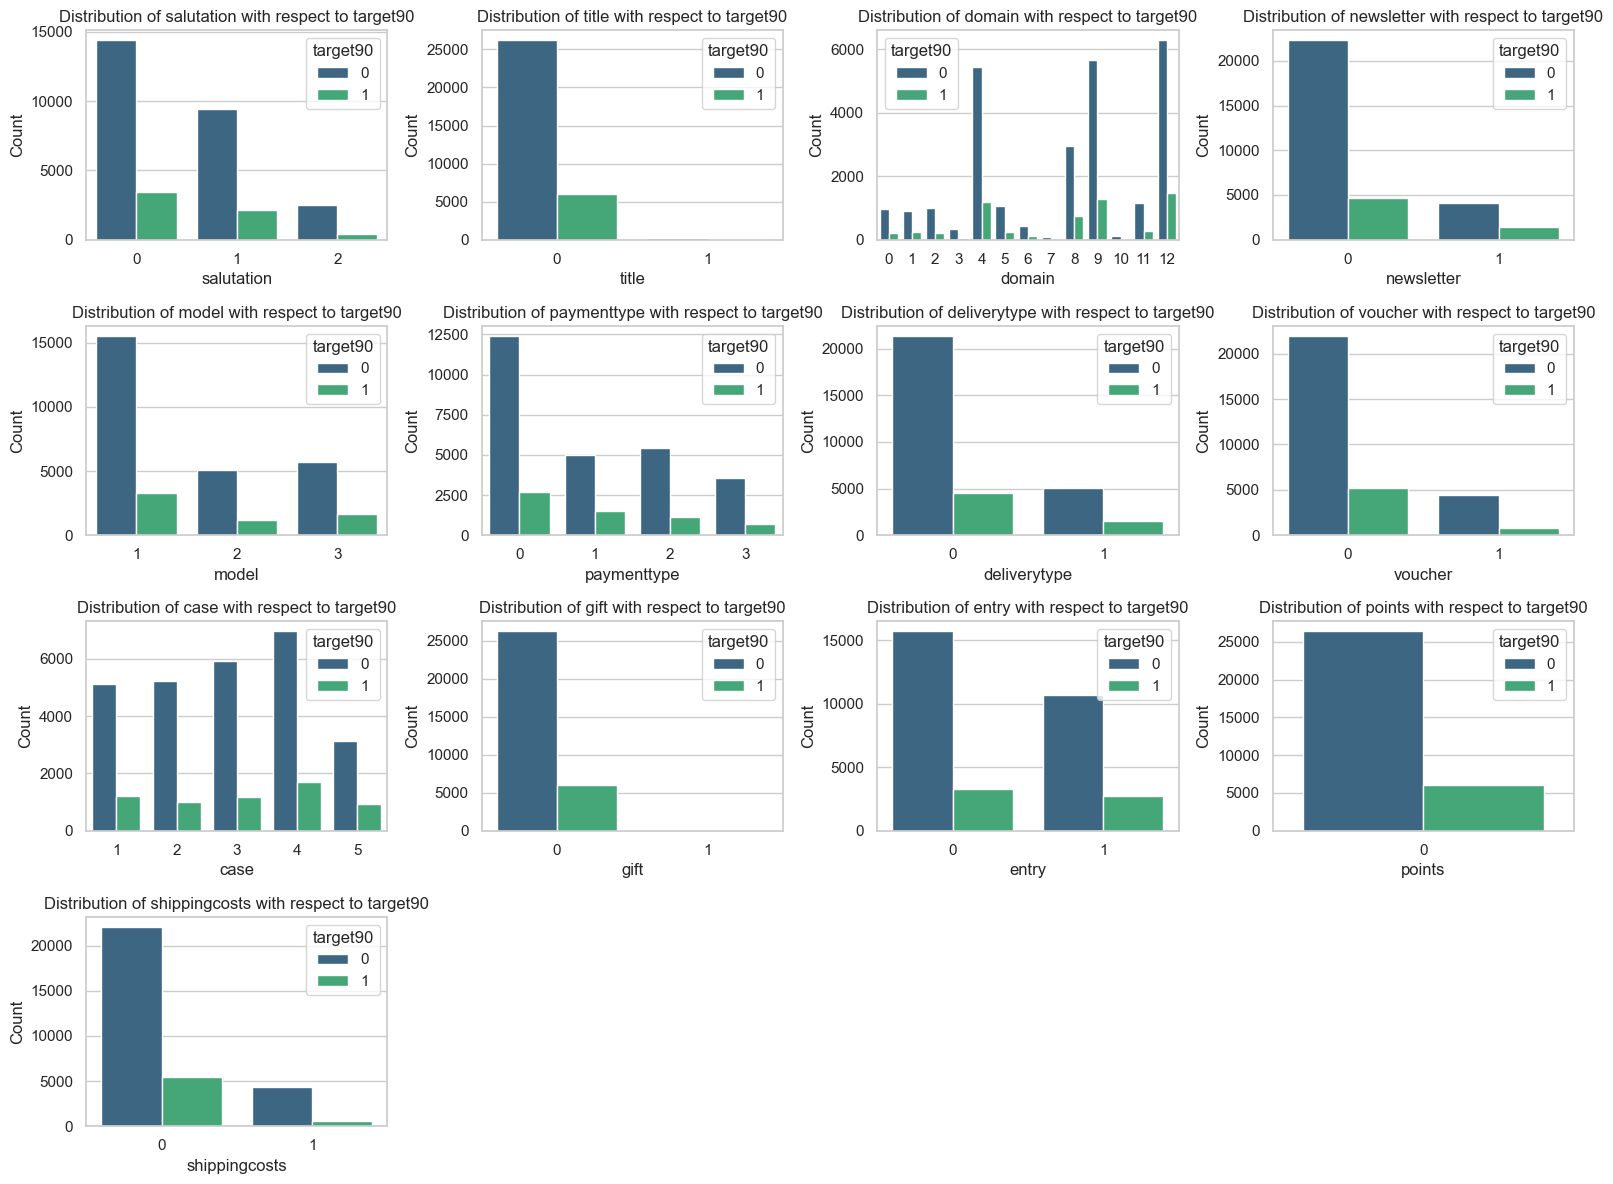

In [24]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create bar plots
for i, feature in enumerate(cat_features):
    sns.countplot(x=feature, hue='target90', data=data, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='target90')
axes[13].set_visible(False) # hide empty subplots
axes[14].set_visible(False)
axes[15].set_visible(False)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

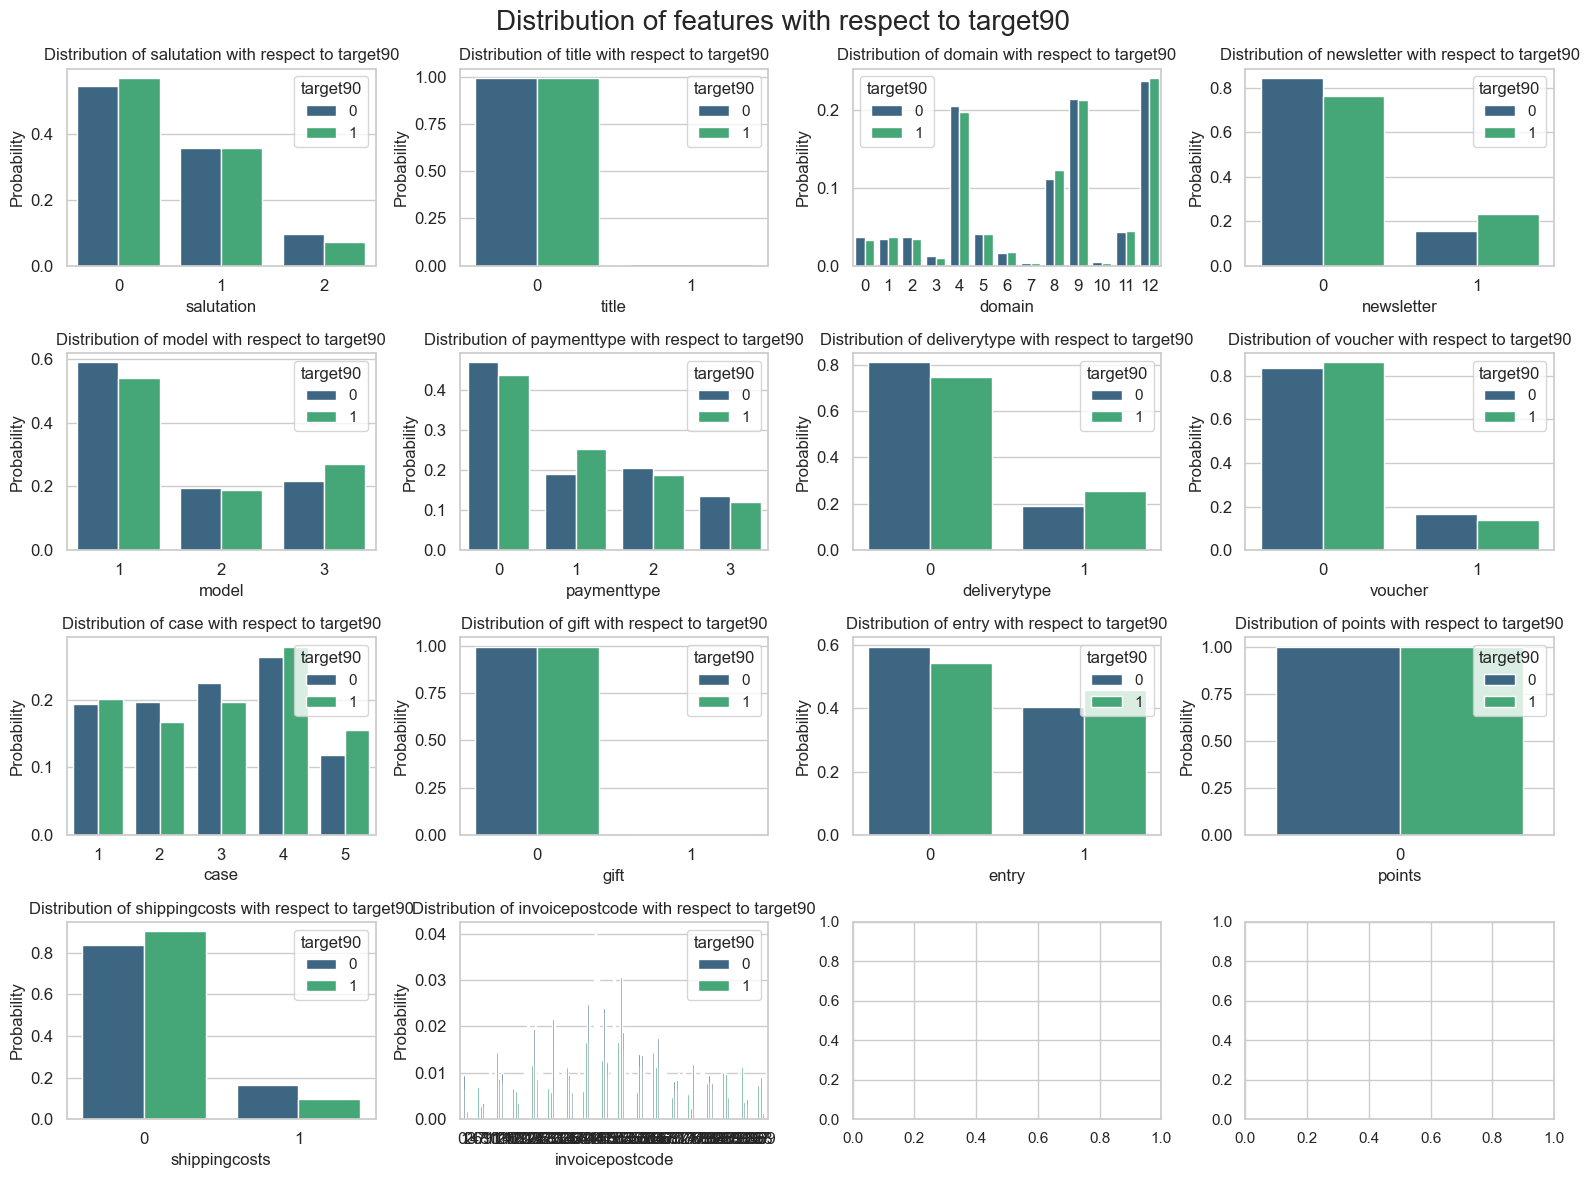

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create bar plots
for i, feature in enumerate(cat_features):
    # Count the occurrences of each combination of 'target90' and the current column
    counts = data.groupby(['target90', feature]).size().reset_index(name='count')
    # Normalize the counts for each hue category
    counts['count'] /= counts.groupby('target90')['count'].transform('sum')

    # Plot the normalized count plot using seaborn
    sns.barplot(x=feature, y='count', hue='target90', data=counts, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Probability')
    axes[i].legend(title='target90')
    axes[i].tick_params(axis='both', labelsize=12)

# Add an overall title
fig.suptitle('Distribution of features with respect to target90', fontsize=20)
axes[13].set_visible(False) # hide empty subplots
axes[14].set_visible(False)
axes[15].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Probability inside target90 = 1 or 0 adds up to 1.

- Sahra's normalized nominal feature graph

**Normalized plots categoricals**

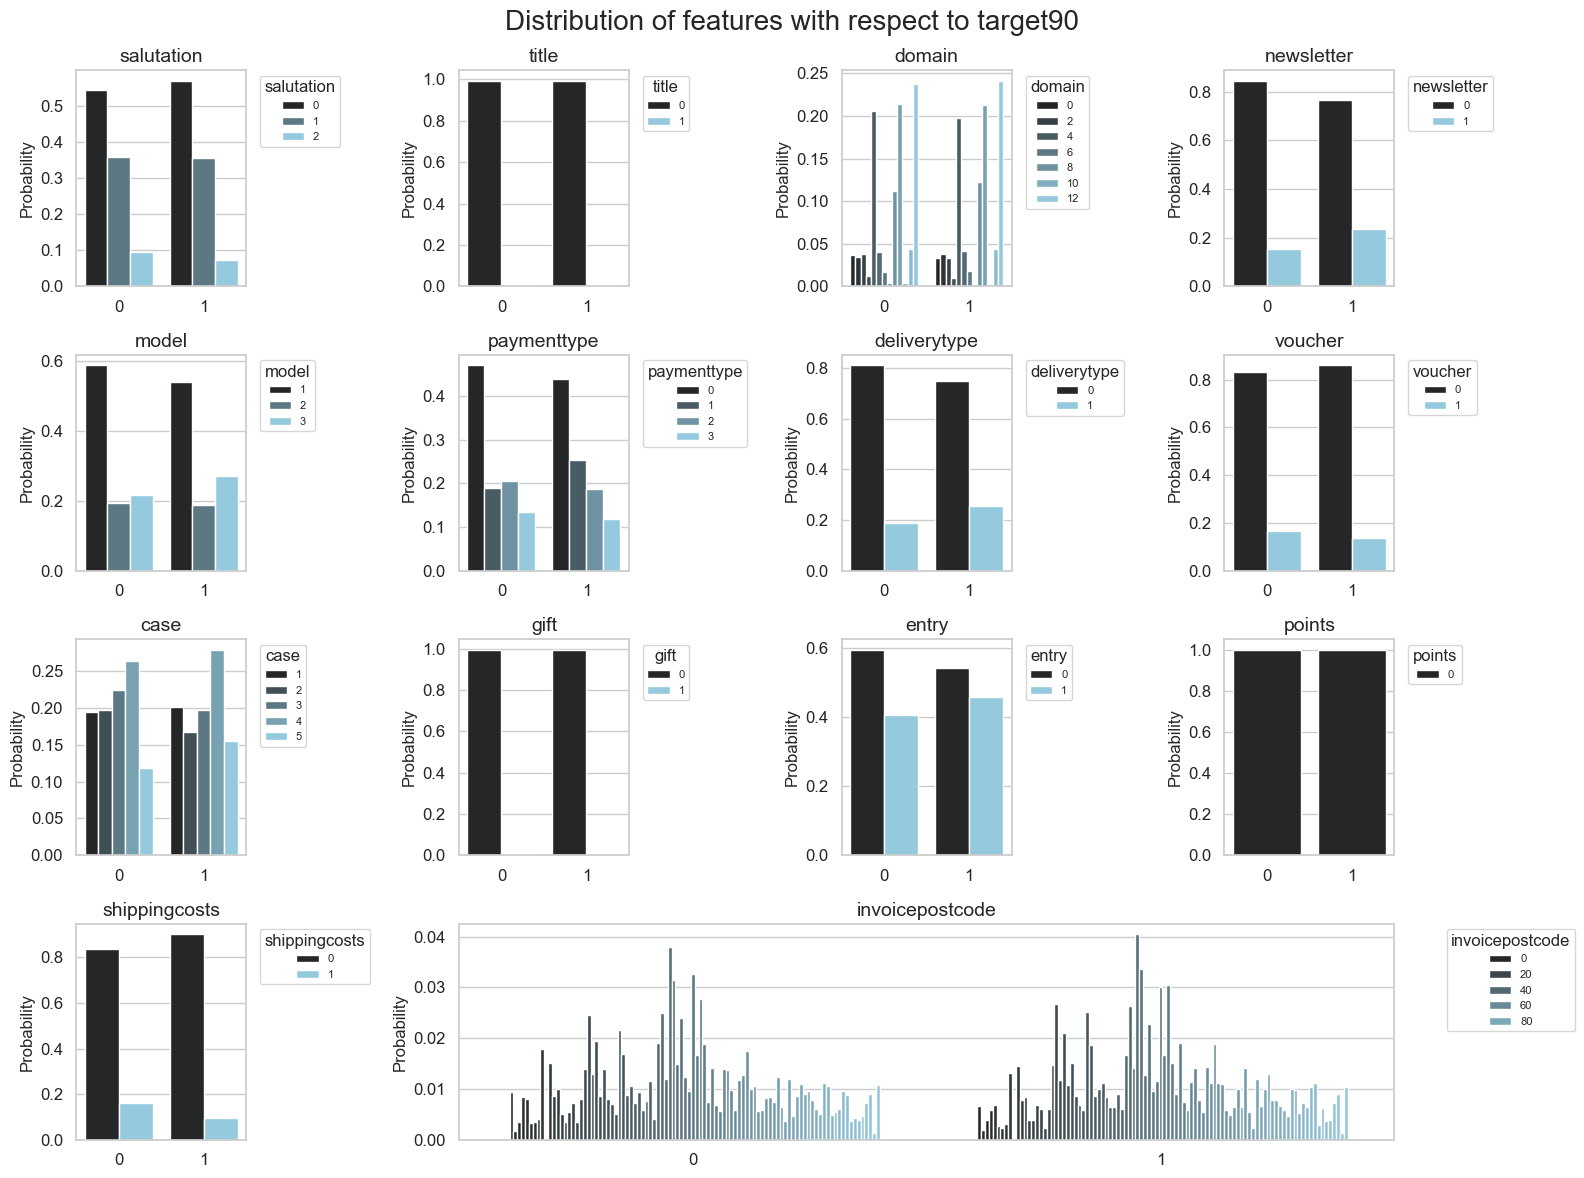

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, ax = plt.subplot_mosaic([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 14, 14]])

# Adjust the size of the overall plot
fig.set_size_inches(16, 12)

# Loop through each nominal feature and create bar plots
for i, feature in enumerate(cat_features):
    # Count the occurrences of each combination of 'target90' and the current column
    counts = data.groupby(['target90', feature]).size().reset_index(name='count')
    # Normalize the counts for each hue category
    counts['count'] /= counts.groupby('target90')['count'].transform('sum')

    # Plot the normalized count plot using seaborn
    sns.barplot(x='target90', y='count', hue=feature, data=counts, palette = 'dark:skyblue', ax=ax[i + 1])
    ax[i+1].set_title(f"{feature}", fontsize=14)
    ax[i+1].set_xlabel('target90')
    ax[i+1].set_ylabel('Probability')
    legend = ax[i+1].legend(title = feature, bbox_to_anchor = (1.05, 1), loc='upper left', fontsize = 8)
    ax[i + 1].set_xlabel('')


    # Adjust font size of axis labels
    ax[i+1].tick_params(axis='both', labelsize=12)

# Add an overall title
fig.suptitle('Distribution of features with respect to target90', fontsize=20)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()


**Save and download plot**

In [ ]:
# Save the plot to a file
fig.savefig('distr_feature_targetclass.png', bbox_inches='tight')
plt.savefig('distr_feature_targetclass.png', bbox_inches='tight')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Distribution of cardinal features with respect to target90

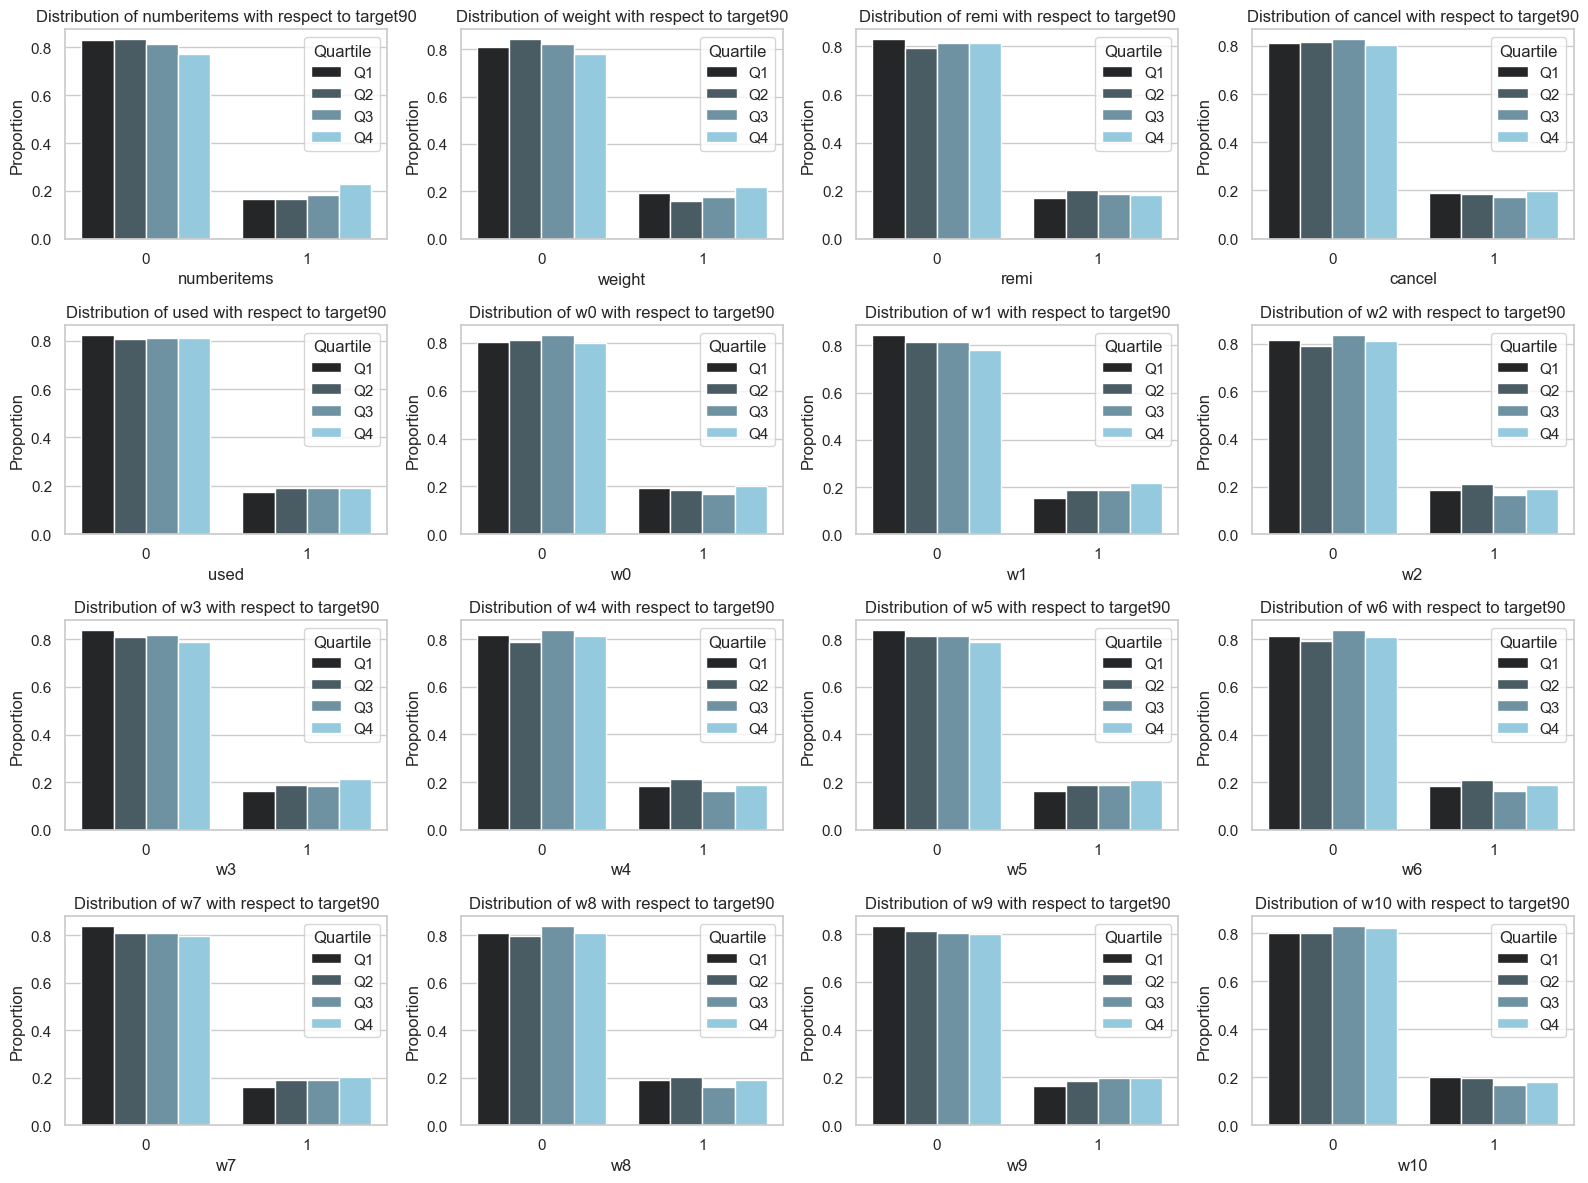

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'data' is your DataFrame and 'cardinal_features' is the list of features
# Update 'target90' with your actual target column name

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a 4x4 subplot layout
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through each nominal feature and create countplots for quartiles
for i, feature in enumerate(cntnous_features):

    # Sort data according to feature
    data = data.sort_values(feature)

    # Get data in 25% slides
    data_25 = data.iloc[:int(0.25 * len(data))]
    data_50 = data.iloc[int(0.25 * len(data)):int(0.5 * len(data))]
    data_75 = data.iloc[int(0.5 * len(data)):int(0.75 * len(data))]
    data_100 = data.iloc[int(0.75 * len(data)):]

    # Compute share of target90 = 1 in each quartile
    data_25_y_1 = data_25['target90'].mean()
    data_50_y_1 = data_50['target90'].mean()
    data_75_y_1 = data_75['target90'].mean()
    data_100_y_1 = data_100['target90'].mean()

    # Compute share of target90 = 0 in each quartile
    data_25_y_0 = 1 - data_25_y_1
    data_50_y_0 = 1 - data_50_y_1
    data_75_y_0 = 1 - data_75_y_1
    data_100_y_0 = 1 - data_100_y_1

    # Create a DataFrame with the computed values
    df = pd.DataFrame({'target90': ['0', '1'], 'Q1': [data_25_y_0, data_25_y_1], 'Q2': [data_50_y_0, data_50_y_1],
                        'Q3': [data_75_y_0, data_75_y_1], 'Q4': [data_100_y_0, data_100_y_1]})
    # Plot the results
    sns.barplot(x='target90', y='value', hue='variable', data=pd.melt(df, ['target90']), ax=axes[i], palette= 'dark:skyblue')
    axes[i].set_title(f'Distribution of {feature} with respect to target90')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Quartile')


# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Self-written function to calculate min, max, mean and meadian of all columns in a data set, first checking whether the variable type is suited
def summary(data):
    stats_list = []  

    for col in data.columns:
        if data[col].dtype in ['int64', 'float64']:
            col_data = data[col]
            col_min = np.round(col_data.min(),2)
            col_max = np.round(col_data.max(),2)
            col_mean = np.round(col_data.mean(),2)
            col_median = np.round(col_data.median(),2)

            
            col_summary = pd.DataFrame({
                "Feature": [col],
                "Minimum": [col_min],
                "Maximum": [col_max],
                "Mean": [col_mean],
                "Median": [col_median]
            })

            # Append the summary DataFrame to the list
            stats_list.append(col_summary)
        else:
            print(f"Column {col} is not suited for these descriptives.")

    # Concatenate all individual summary DataFrames into a single DataFrame
    result = pd.concat(stats_list, ignore_index=True)

    # Set variable name as index
    result.set_index("Feature", inplace=True)

    return result


In [ ]:
summary_data = data.drop(["customernumber", "salutation", "domain", "model", "paymenttype", "invoicepostcode", "case"], axis=1)
summary(summary_data)

---

#### Preprocessing

### Computing delivery delay

    We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will become.

- Filter rows with possibly invalid date-values

In [ ]:
# Spot possible NaTs in date-variables
nat_date = pd.to_datetime(data['date'], errors='coerce')
nat_promised = pd.to_datetime(data['deliverydatepromised'], errors='coerce')
nat_real = pd.to_datetime(data['deliverydatereal'], errors='coerce')

In [ ]:
# Filter rows with invalid date formats (NaT values)
inval_idx_date = data[nat_date.isnull()].index.tolist()
inval_idx_promised = data[nat_promised.isnull()].index.tolist()
inval_idx_real = data[nat_real.isnull()].index.tolist()

# Display incorrect entries of date as string columns
print("\nIncorrect entries of 'date':")
print(data.loc[inval_idx_date, 'date'])

print("\nIncorrect entries of 'deliverydatepromised':")
print(data.loc[inval_idx_promised, 'deliverydatepromised'])

print("\nIncorrect entries of 'deliverydatereal':")
print(data.loc[inval_idx_real, 'deliverydatereal'])


Incorrect entries of 'date':
Series([], Name: date, dtype: object)

Incorrect entries of 'deliverydatepromised':
14955    4746-07-23
15657    4746-11-26
16892    4746-06-13
23111    4746-11-15
23538    4746-05-08
23669    4746-05-15
26727    4746-11-15
27202    4746-10-01
28201    4746-11-18
Name: deliverydatepromised, dtype: object

Incorrect entries of 'deliverydatereal':
3        0000-00-00
15       0000-00-00
28       0000-00-00
29       0000-00-00
31       0000-00-00
            ...    
32397    0000-00-00
32398    0000-00-00
32406    0000-00-00
32410    0000-00-00
32424    0000-00-00
Name: deliverydatereal, Length: 5472, dtype: object


deliverydatepromised: 8 errors

deliverydatereal: 5472 errors


In [ ]:
print(data.loc[inval_idx_promised, 'deliverydatepromised'], data.loc[inval_idx_promised, 'deliverydatereal'])

28201    4746-11-18
23538    4746-05-08
14955    4746-07-23
16892    4746-06-13
23669    4746-05-15
15657    4746-11-26
26727    4746-11-15
27202    4746-10-01
23111    4746-11-15
Name: deliverydatepromised, dtype: object 28201    0000-00-00
23538    0000-00-00
14955    2008-09-06
16892    2008-07-18
23669    2008-06-17
15657    2008-12-29
26727    0000-00-00
27202    2008-11-03
23111    2008-12-18
Name: deliverydatereal, dtype: object


- Replace incorrect 4746 by 2008 according to year of delivery real and convert to datetime

In [ ]:
# Replace incorrect string for year:
data['deliverydatepromised'] = data['deliverydatepromised'].str.replace('4746', '2008')

# Convert date variables to dateformat:
data['date'] = pd.to_datetime(data['date'])
data['deliverydatepromised'] = pd.to_datetime(data['deliverydatepromised'])
data['deliverydatereal'] = pd.to_datetime(data['deliverydatereal'], errors='coerce')

- Build difference between 'promised' and 'real' and check for consistency

In [ ]:
# Calculate difference between promised and real delivery dates (in days)
data['delivery_diff'] = (data['deliverydatereal'] - data['deliverydatepromised']).dt.days

# Explore 'delivery_diff'
print(data['delivery_diff'].describe())

count    26956.000000
mean       -17.260276
std         72.324342
min       -369.000000
25%         -3.000000
50%         -1.000000
75%         -1.000000
max        368.000000
Name: delivery_diff, dtype: float64


In [ ]:
# Asses rows for which delivery_diff min(), max()
min_delivery_diff = data[data['delivery_diff'] == data['delivery_diff'].min()]
max_delivery_diff = data[data['delivery_diff'] == data['delivery_diff'].max()]

# Display rows for min and max delivery_diff
print("Rows with the minimum delivery_diff:")
print(min_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']].head(5))
print(len(min_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']]))

print("\nRows with the maximum delivery_diff:")
print(max_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']].head(5))
print(len(max_delivery_diff[['date', 'deliverydatepromised', 'deliverydatereal', 'delivery_diff']]))


Rows with the minimum delivery_diff:
           date deliverydatepromised deliverydatereal  delivery_diff
1144 2008-04-08           2009-04-13       2008-04-09         -369.0
2023 2008-08-26           2009-08-31       2008-08-27         -369.0
2426 2008-11-25           2009-11-30       2008-11-26         -369.0
3086 2008-05-20           2009-05-25       2008-05-21         -369.0
3260 2008-12-11           2009-12-15       2008-12-11         -369.0
52

Rows with the maximum delivery_diff:
            date deliverydatepromised deliverydatereal  delivery_diff
685   2008-04-02           2008-05-02       2009-05-05          368.0
19923 2008-06-19           2008-06-20       2009-06-23          368.0
2


- Further, check for observations for which 'promised' and 'real' fall within the first quarter of next year, but 'date' doesn't

We want to extract the observations for which the Q1 statement is true and further spot those observations for which the year of promised and real date may not match.

In [ ]:
# Create a new boolean column indicating whether promised and real fall within the first quarter
promised_q1 = data['deliverydatepromised'].dt.quarter == 1
real_q1 = data['deliverydatereal'].dt.quarter == 1

# Create a new boolean column indicating whether date doesn't fall within the first quarter
date_not_q1 = data['date'].dt.quarter != 1

# Filter rows where 'promised' and 'real' fall within the first quarter, but 'date' doesn't
dates_not_in_q1 = data[promised_q1 & real_q1 & date_not_q1]

# Observations for which the years between 'promised' and 'real' in Q1 differ/are incorrect
filtered_years_diff = dates_not_in_q1[dates_not_in_q1['deliverydatepromised'].dt.year != dates_not_in_q1['deliverydatereal'].dt.year]

# Display filtered df
print("Rows where 'promised' and 'real' fall within Q1, but 'date' doesn't and years differ:")
print(filtered_years_diff[['deliverydatepromised', 'deliverydatereal', 'date']])


Rows where 'promised' and 'real' fall within Q1, but 'date' doesn't and years differ:
      deliverydatepromised deliverydatereal       date
443             2010-01-04       2009-01-17 2008-12-30
1196            2010-01-01       2009-01-03 2008-12-29
3709            2010-01-01       2009-03-27 2008-12-29
5597            2010-01-05       2009-02-25 2008-12-31
8024            2010-01-04       2009-03-13 2008-12-30
12129           2010-01-01       2009-02-13 2008-12-29
19087           2010-01-04       2009-03-07 2008-12-30
21727           2010-01-01       2009-03-07 2008-12-30
21813           2010-01-01       2009-01-08 2008-12-29
22219           2010-01-04       2009-01-15 2008-12-30
22968           2010-01-04       2009-01-24 2008-12-30
25921           2010-01-04       2009-01-02 2008-12-31
28212           2010-01-05       2009-02-09 2008-12-31
28402           2010-01-05       2009-03-16 2008-12-31
29373           2010-01-01       2009-01-02 2008-12-29
29881           2010-01-01       2

**Note:** No adjustment of the year needed, as all entries are delayed anyway and 'delay' would be binary encoded. Therefore, we simply adjust the year of 'promised' according to 'date' and build the corrected delivery difference.


In [ ]:
# Adjust the year of the promised date based on the year of the first order
data['adj_deliverydatepromised'] = data.apply(
    lambda row: row['deliverydatepromised'].replace(year=row['date'].year),
    axis=1
)

# Calculate difference between promised and real delivery dates (in days)
data['delivery_diff'] = (data['deliverydatereal'] - data['adj_deliverydatepromised']).dt.days

print(data[['date', 'deliverydatepromised', 'deliverydatereal']].head())

        date deliverydatepromised deliverydatereal
0 2008-12-01           2008-12-03       2008-12-02
1 2008-12-16           2008-12-30       2009-02-03
2 2008-08-19           2008-09-02       2008-08-28
3 2008-06-16           2008-06-17              NaT
4 2008-08-08           2008-08-11       2008-08-08


### Preprocessing for one hot encoding

In [ ]:
# Split the dataframe into features and labels
y = data['target90']
x = data.drop('target90', axis=1)

# Split into train and test with stratified sampling to preserve class balances
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.3, random_state = seed)

# Pipeline for preprocessing of categorical features
preprocess_categorical = Pipeline(steps=[('encoder', OrdinalEncoder())])
# Pipeline for preprocessing of numerical features
preprocess_numerical = Pipeline(steps=[('scaler', MinMaxScaler())])
# Combine preprocessing steps
data_transformer = ColumnTransformer(transformers=[('categorical', preprocess_categorical, cat_features),
                                                   ('numerical', preprocess_numerical, cntnous_features)])
# Combine features
all_features = cat_features + cntnous_features

# Apply transformation to training and test data
x_train = pd.DataFrame(data_transformer.fit_transform(X_train), columns=all_features) # fit and transform data
x_test = pd.DataFrame(data_transformer.transform(X_test), columns=all_features) # only transform data

In [ ]:
# Save transformer for use in model
joblib.dump(data_transformer, "data_transformer.joblib")

['data_transformer.joblib']

---

#### Further setup

- Function to evaluate model performance

In [ ]:
def evaluate_model(y_train, y_train_pred, y_test, y_test_pred):

    # Convert y_train & y_test to np.array, as predictions will also be np.array
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # Initialize variables for training set
    TP_train, FP_train, TN_train, FN_train = 0, 0, 0, 0

    # Initialize variables for test set
    TP_test, FP_test, TN_test, FN_train = 0, 0, 0, 0

    # Calculate training set scores
    TP_train = np.sum((y_train == 1) & (y_train_pred == 1))
    FP_train = np.sum((y_train == 0) & (y_train_pred == 1))
    TN_train = np.sum((y_train == 0) & (y_train_pred == 0))
    FN_train = np.sum((y_train == 1) & (y_train_pred == 0))

    # Calculate test set scores
    TP_test = np.sum((y_test == 1) & (y_test_pred == 1))
    FP_test = np.sum((y_test == 0) & (y_test_pred == 1))
    TN_test = np.sum((y_test == 0) & (y_test_pred == 0))
    FN_test = np.sum((y_test == 1) & (y_test_pred == 0))


    # Calculate training set metrics
    accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train) if (TP_train + TN_train + FP_train + FN_train) != 0 else 0
    precision_train = TP_train / (TP_train + FP_train) if (TP_train + FP_train) != 0 else 0
    sensitivity_train = TP_train / (TP_train + FN_train) if (TP_train + FN_train) != 0 else 0
    specificity_train = TN_train / (TN_train + FP_train) if (TN_train + FP_train) != 0 else 0
    f1_train = 2*TP_train / (2*TP_train + FP_train + FN_train) if (2*TP_train + FP_train + FN_train) != 0 else 0


    # Calculate test set metrics
    accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test) if (TP_test + TN_test + FP_test + FN_test) != 0 else 0
    precision_test = TP_test / (TP_test + FP_test) if (TP_test + FP_test) != 0 else 0
    sensitivity_test = TP_test / (TP_test + FN_test) if (TP_test + FN_test) != 0 else 0
    specificity_test = TN_test / (TN_test + FP_test) if (TN_test + FP_test) != 0 else 0
    f1_test = 2*TP_test / (2*TP_test + FP_test + FN_test) if (2*TP_test + FP_test + FN_test) != 0 else 0

    # Information about distribution of classes in training and test set
    print('Ground truth in training set: \n')
    # Number (and share) of returning customers in training data
    print(f'Number of returning customers training data: {y_train.sum()} ({np.round(y_train.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in training data
    print(f'Number of non-returning customers training data: {len(y_train) - y_train.sum()} ({np.round((1 - y_train.mean())*100,2)}%)')
    # Number (and share) of returning customers in test data
    print(f'Number of returning customers in test data: {y_test.sum()} ({np.round(y_test.mean()*100,2)}%)')
    # Number (and share) of non-returning customers in test data
    print(f'Number of non-returning customers in test data: {len(y_test) - y_test.sum()} ({np.round((1 - y_test.mean())*100,2)}%)')

   # Collect results in a dataframe
    results_df = pd.DataFrame({
        'Set': ['Training', 'Test'],
        'Accuracy': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test], # Share of positives correctly specified among all predicted positives
        'Sensitivity': [sensitivity_train, sensitivity_test], # Share of actual true positive values found
        'Specificity': [specificity_train, specificity_test], # Share of actual true negative values found
        'TP': [TP_train, TP_test],
        'FP': [FP_train, FP_test],
        'TN': [TN_train, TN_test],
        'FN': [FN_train, FN_test],
        'F1': [f1_train, f1_test]
    })

    return results_df

- Function to compute (additional) expected revenue

In [ ]:
def expected_revenue(y, y_pred):
    """
    Calculate the expected revenue based on target labels in y and model predictions.

    Parameters:
    - y (numpy array or pandas Series): True labels indicating returning buyers (1) or non-returning buyers (0).
    - y_pred (numpy array or pandas Series): Model predictions returning buyers (1) or non-returning buyers (0).

    Returns:
    None

    Prints the expected revenue if all customers were sent a voucher and the expected revenue according to a given model prediction.
    """
    # Just in case
    y = np.array(y)
    y_pred = np.array(y_pred)
    # Compute number of total customers in y
    total_customers = len(y)
    # Compute number of returning buyers in y
    rep_buyers = y.sum()
    # Compute number of non-returning buyers in y
    non_buyers = total_customers - rep_buyers
    # Compute expected revenue if all customers were sent a voucher
    expected_revenue1 = non_buyers * 1.5 - rep_buyers * 5 # Revenue gain - loss
    print(f"Expected revenue if all customers were sent a voucher: €{expected_revenue1}")

    # Compute TN and FN for model predictions
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    # Compute revenue gain and loss
    rev_gain = TN * 1.5
    rev_loss = FN * 5
    expected_revenue2 = rev_gain - rev_loss
    percentage_gain = ((expected_revenue2 - expected_revenue1) / expected_revenue1) * 100
    print(f"Expected Revenue according to model: €{expected_revenue2}, this is a percentage gain of: %{percentage_gain:.2f}")

- Constructing the training data set

In [ ]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(data)

delivpostcode 31036
advertisingdatacode 25905
deliverydatereal 5472
delivery_diff 5472


We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values.  

In [ ]:
count_na(x_train)

In [ ]:
disregarded_columns = []
for col in data.columns:
    if col not in x_train.columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['customernumber', 'date', 'datecreated', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'target90', 'delivery_diff', 'adj_deliverydatepromised']


- **Customernumber**: We don't expect the customernumer assigned to an individual to have a systematic influence on a customer's re-purchase probability.
- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
(- **Invoicepostcode**: We dont't expect the postcode of the invoice to have a systematic influence on a customer's re-purchase probability.)
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Target90**: This is the label we want to predict, therefore we do not include it in the training process.
- **Delay**:  However, even though considering delays as promising new binary feature using the information of delivery_diff, as we still encounter 5472 missing values in deliverydatereal and could not come up with a fitting imputation strategy, we decide to disregard.

---

### RandomForestClassifier

- First hyperparameter-tuning run with RandomizedSearchCV

In [ ]:
# Set number of parameter sets to try
n_iterations = 500
# Maybe use less to demonstrate better fit of second model

In [ ]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(10,30)
min_samples_split = range(10,20)
min_samples_leaf = range(5,20)
n_estimators = range(80,150)
criterion = ['gini', 'log_loss', 'entropy']
class_weight = [{1: 5, 0: 1}, 'balanced' ]

# Collect in dictionary
param_dist = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators, 'criterion': criterion, 'class_weight': class_weight}

# Set up forest classifier
forest = RandomForestClassifier(bootstrap = True, random_state = seed)

# Set up RandomizedSearchCV
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = "balanced_accuracy", random_state = seed) # suited for imbalanced data sets

# Fit it to the data
forest_cv.fit(x_train,y_train) # does it automatically use best parameters for prediction afterwards?

# 30 min for 5000 fits

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 5},
                                                         'balanced'],
                                        'criterion': ['gini', 'log_loss',
                                                      'entropy'],
                                        'max_depth': range(10, 30),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(80, 150)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get model predictions for training set
y_train_pred = forest_cv.predict(x_train)
# Get model predictions for test set
y_test_pred = forest_cv.predict(x_test)
# Evaluate performance of cross-validated model
evaluate_model(y_train, y_train_pred, y_test, y_test_pred)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.585312   0.274658     0.744806     0.548719  3155  8332  10131   
1      Test  0.551033   0.241965     0.659504     0.526156  1197  3750   4164   

     FN        F1  
0  1081  0.401323  
1   618  0.354037

- Second hyperparameter-tuning run around best parameters from previous run

In [ ]:
# Grab optimal parameters from previous CV
best_depth = forest_cv.best_params_["max_depth"]
best_split = forest_cv.best_params_["min_samples_split"]
best_leaf = forest_cv.best_params_["min_samples_leaf"]
best_est = forest_cv.best_params_["n_estimators"]

# Set range around previous optimal parameters to search for even better parameters
max_depth = range(best_depth - 3, best_depth + 3)
min_samples_split = range(best_split - 3, best_split + 3)
min_samples_leaf = range(best_leaf - 3, best_leaf + 3)
n_estimators = range(best_est - 5, best_est + 5)

# Collect in dicionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest
forest = RandomForestClassifier(criterion = forest_cv.best_params_["criterion"], class_weight = 'balanced', bootstrap = True, random_state = seed)
# Set up RandomizedSearchCV
forest_cv2 = RandomizedSearchCV(forest, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
forest_cv2.fit(x_train, y_train)
# 19 min for 5000 fits

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='log_loss',
                                                    random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(8, 14),
                                        'min_samples_leaf': range(14, 20),
                                        'min_samples_split': range(15, 21),
                                        'n_estimators': range(135, 145)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get predictions for training data
y_train_pred_cv2 = forest_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_cv2 = forest_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_cv2, y_test, y_test_pred_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.675140   0.309910     0.603872     0.691491  2558  5696  12767   
1      Test  0.642409   0.265502     0.519008     0.670710   942  2606   5308   

     FN        F1  
0  1678  0.409608  
1   873  0.351296

In [ ]:
# Expected revenue of first RF model
expected_revenue(y_test, forest_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3156.0, this is a percentage gain of: %12.88


In [ ]:
# Expected revenue of second RF model
expected_revenue(y_test, forest_cv2.predict(x_test)) # better than first RF model

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €3597.0, this is a percentage gain of: %28.65


In [ ]:
# Random 10 iterations, rev gain 28% best params:
forest_cv2.best_params_

{'n_estimators': 143,
 'min_samples_split': 16,
 'min_samples_leaf': 17,
 'max_depth': 11}

{'n_estimators': 143,
 'min_samples_split': 16,
 'min_samples_leaf': 17,
 'max_depth': 11}

---

### Ada Boost

In [ ]:
# Set number of parameter sets to try
n_iterations = 500

- First hyperparameter tuning run for AdaBoostClassifier

In [ ]:
# Setup ranges for different parameters for hyperparameter tuning
n_estimators = range(10,50)
learning_rate = np.arange(0.5, 10, 0.25) # In Adaboost learning rate can go to infinity (weights of previous misclassifications)
estimator = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)]
algorithm = ['SAMME', 'SAMME.R']
# No option to set class_weight in AdaBoostClassifier

# Collect in dictionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "estimator": estimator, "algorithm": algorithm}

# Set up AdaBoost classifier
ada = AdaBoostClassifier(random_state = seed)
# Set up RandomizedSearchCV
ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs = -1, verbose = 1, n_iter = n_iterations, cv = 5, scoring = 'balanced_accuracy', random_state = seed)
# Fit it to the data
ada_cv.fit(x_train,y_train)

# 13.5 min for 5000 fits

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'estimator': [DecisionTreeClassifier(max_depth=1),
                                                      DecisionTreeClassifier(max_depth=2),
                                                      DecisionTreeClassifier(max_depth=3)],
                                        'learning_rate': array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75,
       6.  , 6.25, 6.5 , 6.75, 7.  , 7.25, 7.5 , 7.75, 8.  , 8.25, 8.5 ,
       8.75, 9.  , 9.25, 9.5 , 9.75]),
                                        'n_estimators': range(10, 50)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get predictions for training data
y_train_pred_ada_cv = ada_cv.predict(x_train)

# Get predictions for test data
y_test_pred_ada_cv = ada_cv.predict(x_test)

# Evaluate performance
evaluate_model(y_train, y_train_pred_ada_cv, y_test, y_test_pred_ada_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.733821   0.263736      0.23796     0.847587  1008  2814  15649   
1      Test  0.726488   0.247613      0.22865     0.840662   415  1261   6653   

     FN        F1  
0  3228  0.250186  
1  1400  0.237754

- Second hyperparameter tuning run for AdaBoostClassifier

In [ ]:
# Grab optimal parameters from previous CV
best_n_estimators = ada_cv.best_params_["n_estimators"]
best_learningrate = ada_cv.best_params_["learning_rate"]
estimator = ada_cv.best_params_["estimator"]
algorithm = ada_cv.best_params_["algorithm"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 10, best_n_estimators + 10)
learning_rate = np.arange(best_learningrate - 2, best_learningrate + 2, 0.1)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate}

# Set up forest
ada = AdaBoostClassifier(estimator = estimator, algorithm = algorithm, random_state = seed)
# Set up RandomizedSearchCV
ada_cv2 = RandomizedSearchCV(ada, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
ada_cv2.fit(x_train, y_train)
#

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=1),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ,
       4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3,
       5.4]),
                                        'n_estimators': range(16, 36)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get predictions for training data
y_train_pred_ada_cv2 = ada_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_ada_cv2 = ada_cv2.predict(x_test)
# Evalute performance
evaluate_model(y_train, y_train_pred_ada_cv2, y_test, y_test_pred_ada_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity    TP    FP     TN  \
0  Training  0.733821   0.263736      0.23796     0.847587  1008  2814  15649   
1      Test  0.726488   0.247613      0.22865     0.840662   415  1261   6653   

     FN        F1  
0  3228  0.250186  
1  1400  0.237754

In [ ]:
# Expected revenue of second AdaBoost model
expected_revenue(y_test, ada_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2979.5, this is a percentage gain of: %6.56


In [ ]:
# Expected revenue of second AdaBoost model
expected_revenue(y_test, ada_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2979.5, this is a percentage gain of: %6.56


---

### XGBoost

In [ ]:
# Set number of parameter sets to try
n_iterations = 500

- First hyperparameter tuning run for XGBClassifier

In [ ]:
# Setup parameter distributions for hyperparameter tuning
max_depth = range(1, 4)
n_estimators = range(20, 80)
learning_rate = np.linspace(0.1, 1, 9)

param_dist = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Set up GradientBoostingClassifier
xgb = XGBClassifier(random_state = seed)

# Set up RandomizedSearchCV
xgb_cv = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = n_iterations, scoring = 'balanced_accuracy', random_state = seed)

# Fit it to the data
xgb_cv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1   , 0.2125, 0.325 , 0.4375, 0.55  , 0.6625, 0.775 , 0.8875,
       1.    ]),
                                        'max_depth': range(1, 4),
                                        'n_estimators': range(20, 80)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get predictions for training data
y_train_pred_xgb_cv = xgb_cv.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv = xgb_cv.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv, y_test, y_test_pred_xgb_cv)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity   TP   FP     TN  \
0  Training  0.822679   0.692168     0.089707     0.990847  380  169  18294   
1      Test  0.805222   0.324561     0.040771     0.980541   74  154   7760   

     FN        F1  
0  3856  0.158830  
1  1741  0.072442

- Second hyperparameter tuning run for XGBClassifier

In [ ]:
# Setup range of parameters around previous optimal parameters
best_n_estimators = xgb_cv.best_params_["n_estimators"]
best_learningrate = xgb_cv.best_params_["learning_rate"]
best_depth = xgb_cv.best_params_["max_depth"]

# Set range around previous optimal parameters to search for even better parameters
n_estimators = range(best_n_estimators - 5, best_n_estimators + 5)
learning_rate = np.arange(best_learningrate - 0.3, best_learningrate + 0.3, 0.05)
max_depth = range(best_depth - 2, best_depth + 2)

# Collect in dicionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate, "max_depth": max_depth}

# Set up forest
xgb = XGBClassifier(random_state = seed)
# Set up RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = n_iterations, scoring = "balanced_accuracy", random_state = seed)
# Fit it to the data
xgb_cv2.fit(x_train, y_train) # does it automatically use best parameters?

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 ,
       1.25, 1.3 ]),
                                        'max_depth': range(1, 5),
                                        'n_estimators': range(62, 72)},
                   random_state=1, scoring='balanced_accuracy', verbose=1)

In [ ]:
# Get predictions for training data
y_train_pred_xgb_cv2 = xgb_cv2.predict(x_train)
# Get predictions for test data
y_test_pred_xgb_cv2 = xgb_cv2.predict(x_test)
# Evaluate model performance
evaluate_model(y_train, y_train_pred_xgb_cv2, y_test, y_test_pred_xgb_cv2)

Ground truth in training set: 

Number of returning customers training data: 4236 (18.66%)
Number of non-returning customers training data: 18463 (81.34%)
Number of returning customers in test data: 1815 (18.66%)
Number of non-returning customers in test data: 7914 (81.34%)


Set  Accuracy  Precision  Sensitivity  Specificity   TP   FP     TN  \
0  Training  0.834222   0.776608     0.156752     0.989655  664  191  18272   
1      Test  0.797718   0.292683     0.059504     0.967020  108  261   7653   

     FN        F1  
0  3572  0.260852  
1  1707  0.098901

In [ ]:
# Expected revenue of first XGB model
expected_revenue(y_test, xgb_cv.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2935.0, this is a percentage gain of: %4.97


In [ ]:
# Expected revenue of second XGB model
expected_revenue(y_test, xgb_cv2.predict(x_test))

Expected revenue if all customers were sent a voucher: €2796.0
Expected Revenue according to model: €2944.5, this is a percentage gain of: %5.31


---

#### Save of best-performing model

In [18]:
# Test-wise save of the model
joblib.dump(forest_cv2, "forest_cv2.joblib")

NameError: name 'forest_cv2' is not defined

---

### Model interpretations

Explain model predictions of best performing model: Random Forest

- Feature importance

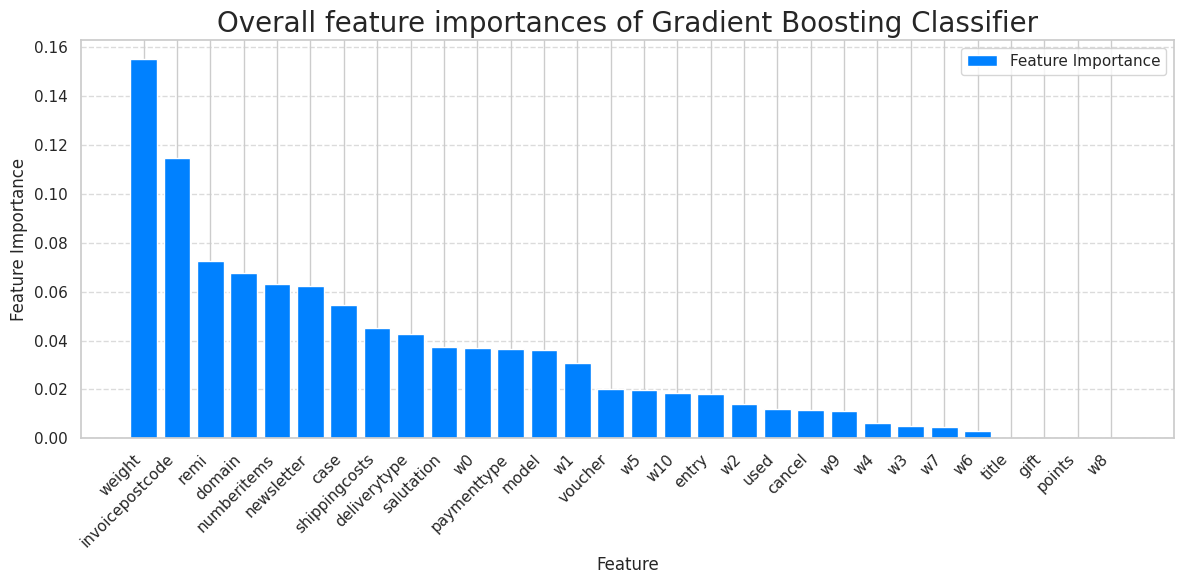

In [ ]:
# Set model to best estimator from CV
model = forest_cv2.best_estimator_

# Sort feature importances in descending order
sorted_indices = np.argsort(model.feature_importances_)[::-1]
srtd = model.feature_importances_[sorted_indices]

# Plot feature importance
fig = plt.figure(figsize=(12, 6))
ax = fig.gca() #get current axis
ax.bar(range(x_train.shape[1]), srtd, color = "#0081ff", width = 0.8)
ax.set_xticks(np.arange(x_train.shape[1]))
ax.set_xticklabels([f'{x_train.columns[col]}' for col in sorted_indices], rotation=45, ha='right')
ax.set_xlabel('Feature', fontsize = 12)
ax.set_ylabel('Feature Importance', fontsize = 12)
ax.set_title('Overall feature importances of Gradient Boosting Classifier', fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(['Feature Importance'])
plt.tight_layout()


- Permutation feature importance

In [ ]:
# Set list of metrics to compute feature importance for
metrics = ['accuracy', 'precision', 'recall', 'f1'] # specificity not a valid scoring metric
# Initialize empty dictionary to store results
pfi_scores = {}
# Loop over all metrics
for metric in metrics:
    print('Computing permutation importance with {0}...'.format(metric))
    pfi_scores[metric] = permutation_importance(model, x_test, y_test, scoring = metric, n_repeats = 30, random_state = seed)

Computing permutation importance with accuracy...
Computing permutation importance with precision...
Computing permutation importance with recall...
Computing permutation importance with f1...


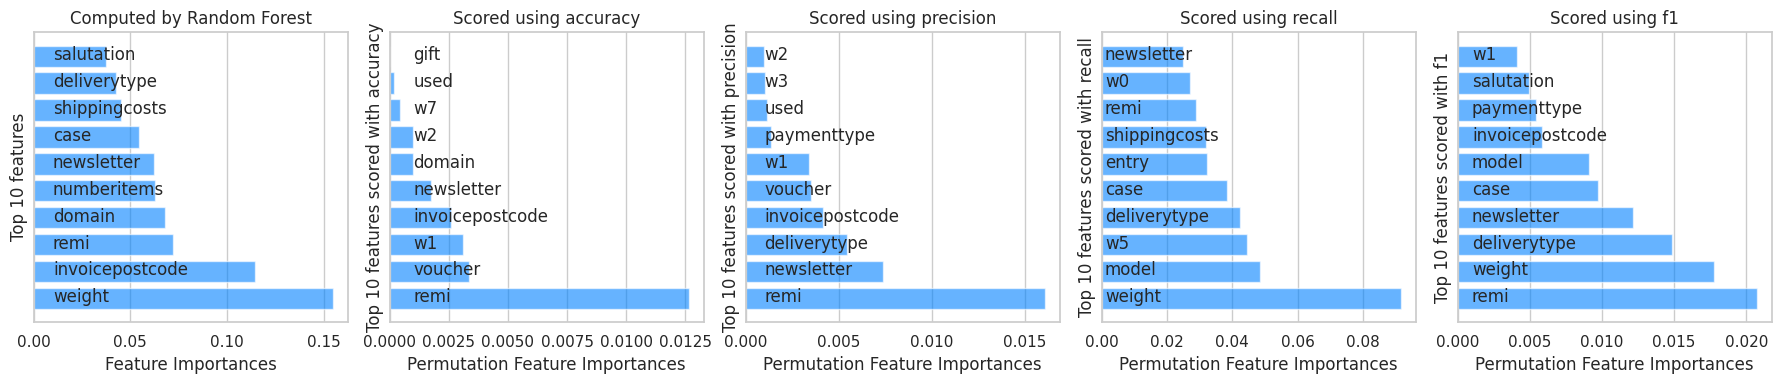

In [ ]:
# Visualization of results
features = x_test.columns.values
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (18, 4))

scores = model.feature_importances_
features = x_test.columns.to_numpy()
srtd = np.argsort(-scores) # sort descending and get indices

top = 10 # Top 10 features
ax[0].barh(y = np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha = 0.6) # regular feature importance of RF
for i in range(top):
    ax[0].text(0.01, i-0.15, features[srtd[i]]) # add feature names to plot
ax[0].set_yticks([])
ax[0].set_ylabel('Top {0} features'.format(top));
ax[0].set_xlabel('Feature Importances')
ax[0].set_title('Computed by Random Forest')

for k, metric in enumerate(metrics):
    scores = pfi_scores[metric]['importances_mean']
    srtd = np.argsort(-scores)

    ax[k+1].barh(y=np.arange(0, top), width = scores[srtd[:top]], color = '#0081ff', alpha = 0.6)
    for i in range(top):
        ax[k+1].text(0.001, i-0.15, features[srtd[i]])
    ax[k+1].set_yticks([])
    ax[k+1].set_ylabel('Top {0} features scored with {1}'.format(top, metric));
    ax[k+1].set_xlabel('Permutation Feature Importances')
    ax[k+1].set_title('Scored using {0}'.format(metric))

plt.tight_layout()

##### Global model agnostic methods

- Partial dependence plots

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


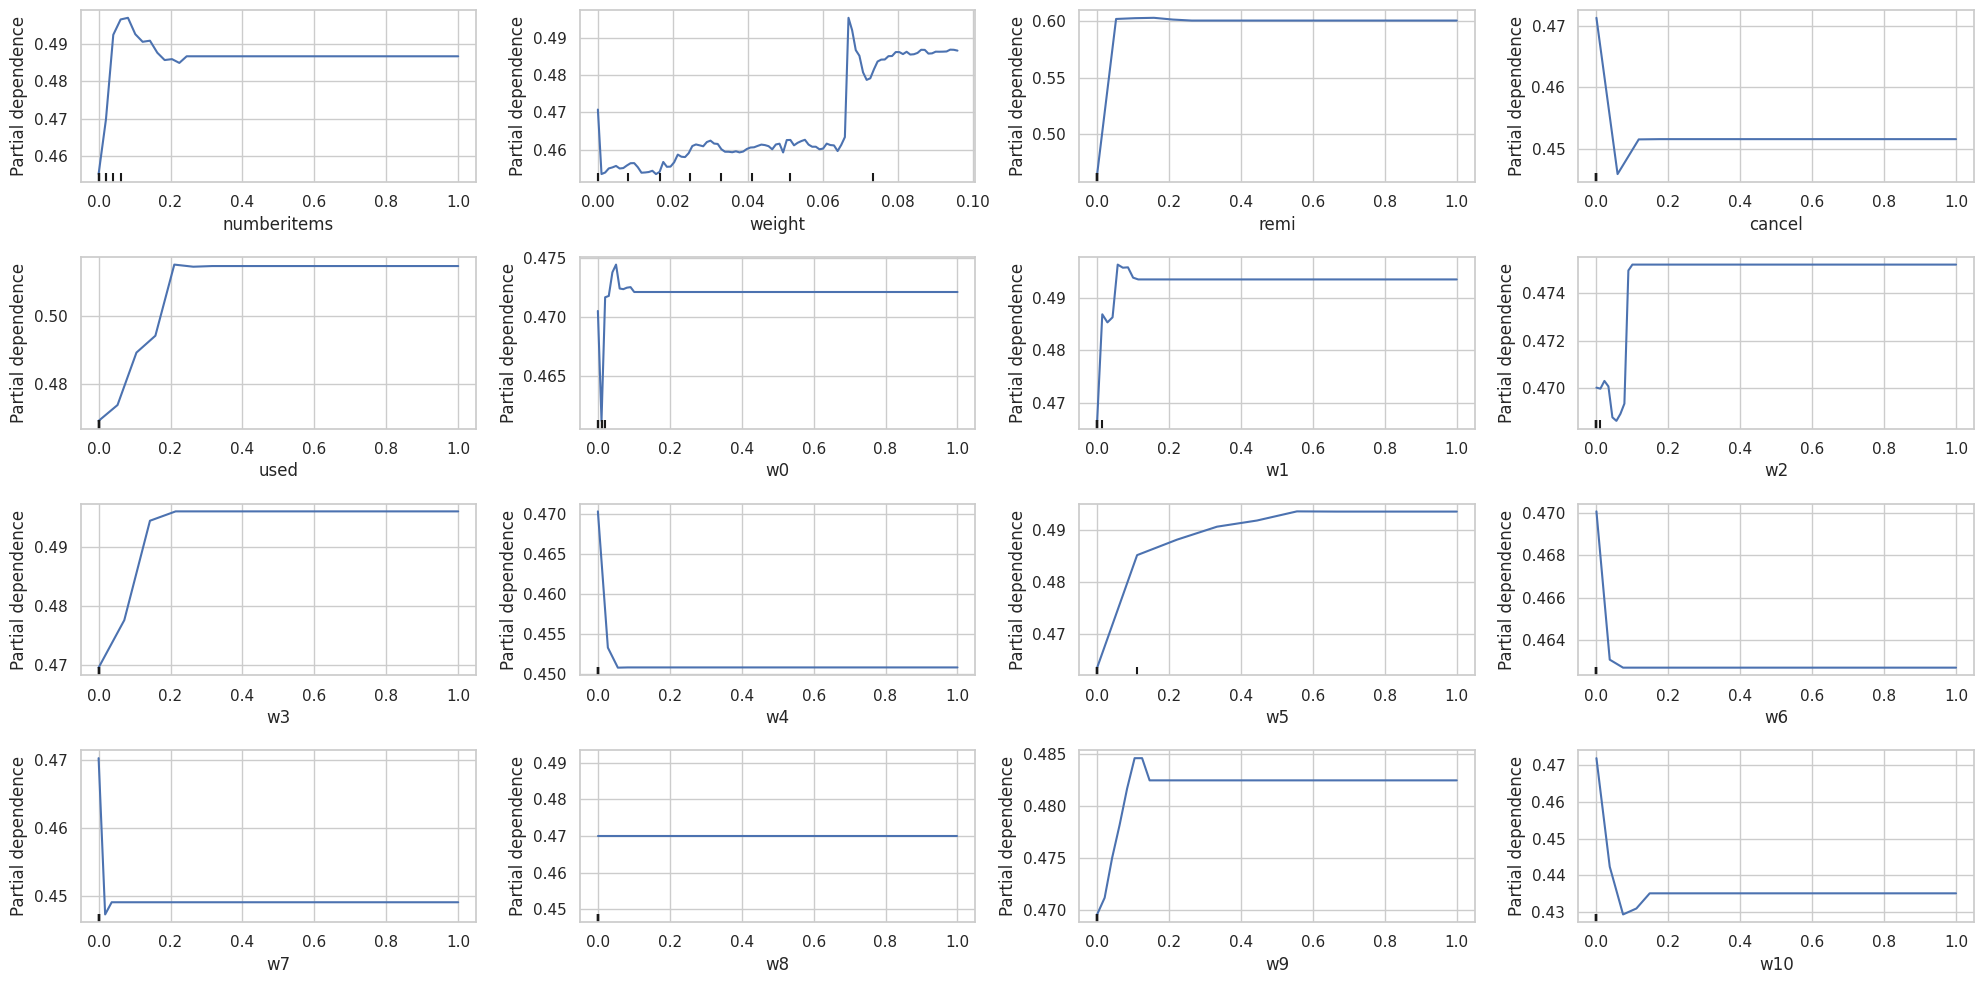

In [ ]:
# Continuous features
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

# Iterate through both features and axes
for feature, axis in zip(cntnous_features, ax.flatten()):
    pdp.from_estimator(forest_cv2.best_estimator_, x_train,
                       features=[feature],  # Use only one feature at a time
                       feature_names=list(x_train.columns),
                       kind='average',
                       response_method = "predict_proba", # Use predict_proba to get probability of class 1
                       ax=axis)

    # Set the title for each subplot
    # axis.set_title(feature, fontsize = 12)

plt.tight_layout()
plt.show()

- Global surrogate model

In [ ]:
# Compute the model
yb_train_pred = forest_cv2.predict(x_train)  # Training set predictions of the black-box (RF) model
yb_test_pred = forest_cv2.predict(x_test)  # Test set predictions of the black-box (RF) model

acc={}

# Loop over max_depth
depth_limits = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for max_depth in depth_limits:
    print('Surrogate max-depth = {0}'.format(max_depth))
    surrogate = DecisionTreeClassifier(max_depth = max_depth, criterion = 'gini',
                                       min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
    surrogate.fit(x_train, yb_train_pred)
    ys_train_pred = surrogate.predict(x_train)
    ys_test_pred = surrogate.predict(x_test)

    acc[max_depth] = {'trn': {'black-box': accuracy_score(y_train, yb_train_pred),
                                   'surrogate': accuracy_score(y_train, ys_train_pred),
                                   'r2': r2_score(yb_train_pred, ys_train_pred)},
                           'tst': {'black-box': accuracy_score(y_test, yb_test_pred),
                                   'surrogate': accuracy_score(y_test, ys_test_pred),
                                   'r2': r2_score(yb_test_pred, ys_test_pred)}} # r_squared as in regression

Surrogate max-depth = 2
Surrogate max-depth = 3
Surrogate max-depth = 4
Surrogate max-depth = 5
Surrogate max-depth = 6
Surrogate max-depth = 7
Surrogate max-depth = 8
Surrogate max-depth = 9
Surrogate max-depth = 10


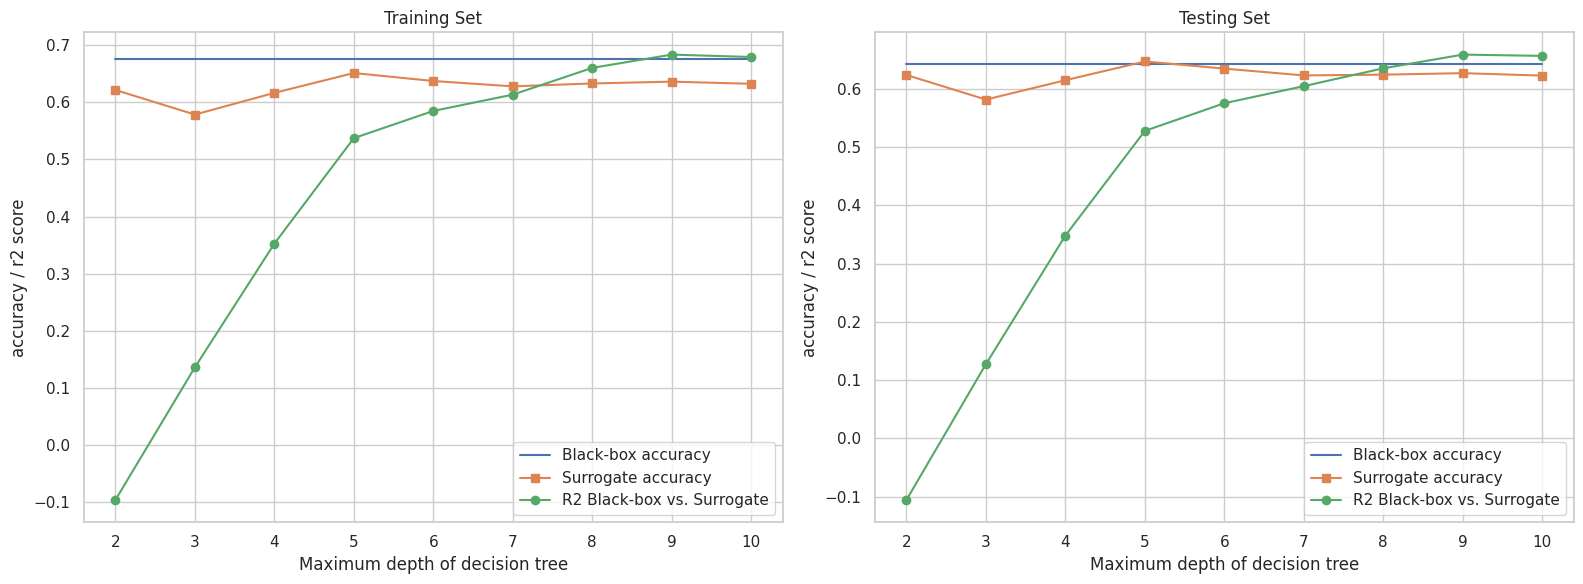

In [ ]:
# Visualization of results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

fig_labels = ['Training Set', 'Testing Set']
markers = [None, 's', 'o']
for i, dset in enumerate(['trn', 'tst']):
    for j, curve in enumerate(['black-box', 'surrogate', 'r2']):
        z = [acc[mleaf][dset][curve] for mleaf in depth_limits]
        ax[i].plot(depth_limits, z, marker=markers[j])
    ax[i].legend(['Black-box accuracy', 'Surrogate accuracy', 'R2 Black-box vs. Surrogate'])
    ax[i].set_title(fig_labels[i])
    ax[i].set_xlabel('Maximum depth of decision tree')
    ax[i].set_ylabel('accuracy / r2 score')
    ax[i].set_xticks(depth_limits)
plt.tight_layout()

Visual inspection of the graphs above suggests that a maximum depth of 6 seems to be an adequate parameter value. Here, the model performs well enough while still being rather easy to interpret.

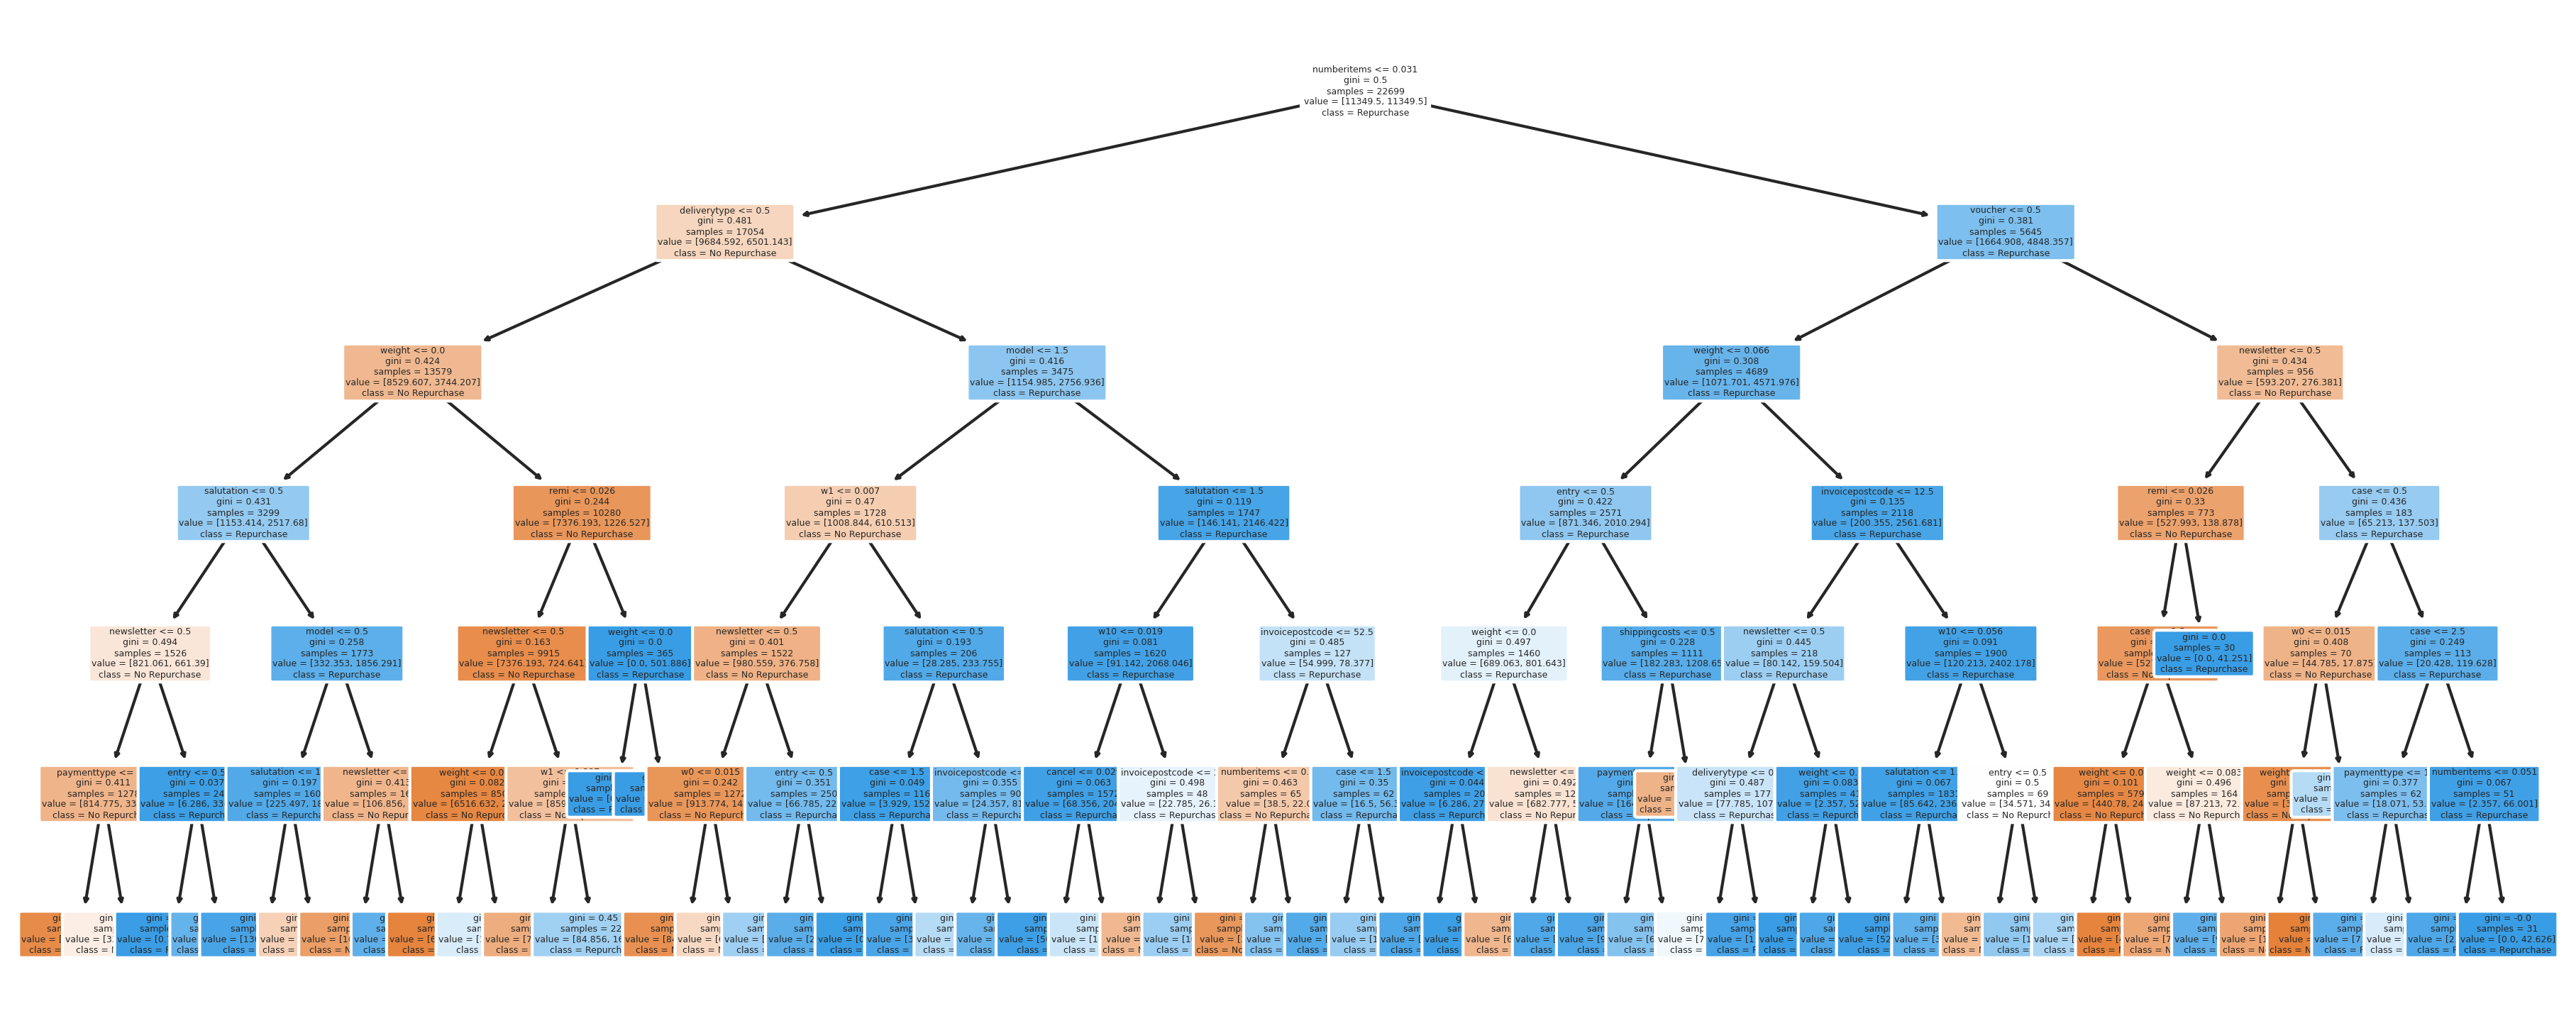

In [ ]:
# Set up surrogate model as decision tree with max_depth = 6
surrogate = DecisionTreeClassifier(max_depth = 6, criterion = 'gini', min_samples_leaf = 20, class_weight = 'balanced', random_state = seed)
surrogate.fit(x_train, yb_train_pred)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(surrogate, fontsize = 3, feature_names = x_train.columns.values,
          rounded=True, filled=True, ax = ax, class_names = ["No Repurchase", "Repurchase"]) # in order of surrogate.classes_
fig.savefig('Regression Tree.PNG')

##### Local model agnostic methods (LIME)

- Explain one prediction instance of our trained model

- Explain one prediction instance of our trained model

In [ ]:
cat_features = ['title', 'newsletter', 'deliverytype', 'invoicepostcode', 'voucher',
                'case', 'gift', 'entry', 'points', 'shippingcosts', 'paymenttype',
                'salutation']#, 'delay']

cat_idx = np.array([cat_features.index(f) for f in cat_features])


lime_explainer = lime_tabular.LimeTabularExplainer(x_train.values,
                                              feature_names=list(x_train.columns),
                                              class_names=['No purchase', 'Repurchase'],
                                              categorical_features=cat_idx,
                                              kernel_width=75.0,
                                              categorical_names=cat_features,
                                              discretize_continuous=False)

In [ ]:
# Explain a single instance using example index:
exp = lime_explainer.explain_instance(x_test.iloc[3000], forest_cv2.predict_proba)
exp.show_in_notebook(show_table=False, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [ ]:
# Explain a single instance using example index:
exp = lime_explainer.explain_instance(x_test.iloc[3000], forest_cv2.predict_proba)
exp.show_in_notebook(show_table=False, show_all=False)
# Save explanation to html file
exp.save_to_file('lime_explanation.html')

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Shapley values

In [ ]:
shap_explainer = shap.Explainer(forest_cv2.best_estimator_)
shap_values = shap_explainer.shap_values(x_test)

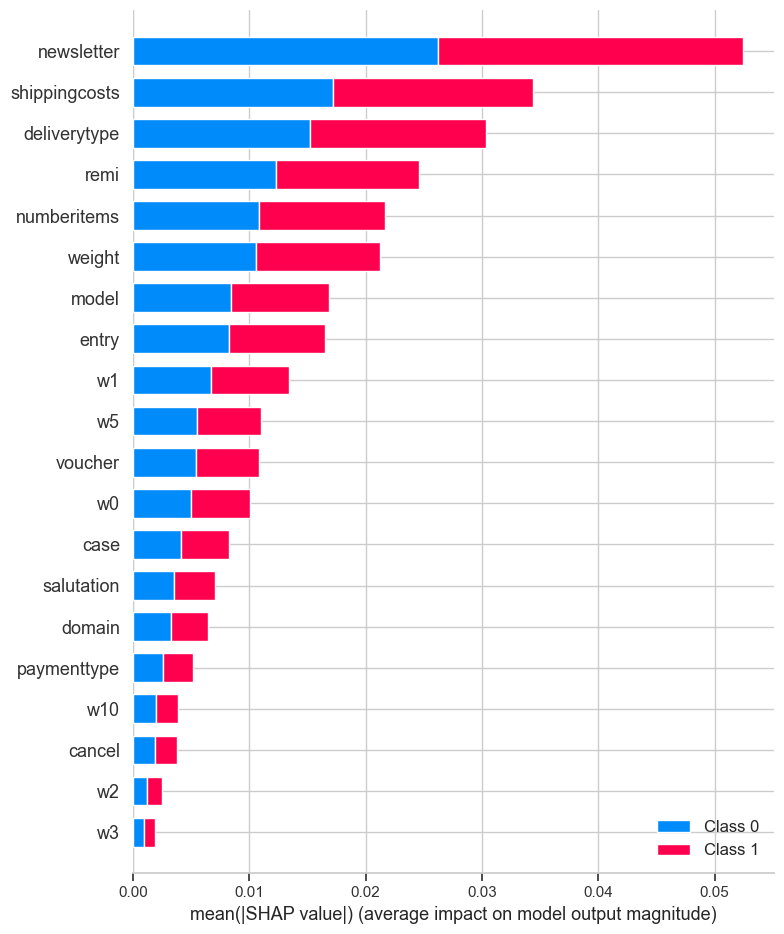

In [ ]:
shap.summary_plot(shap_values, x_test)

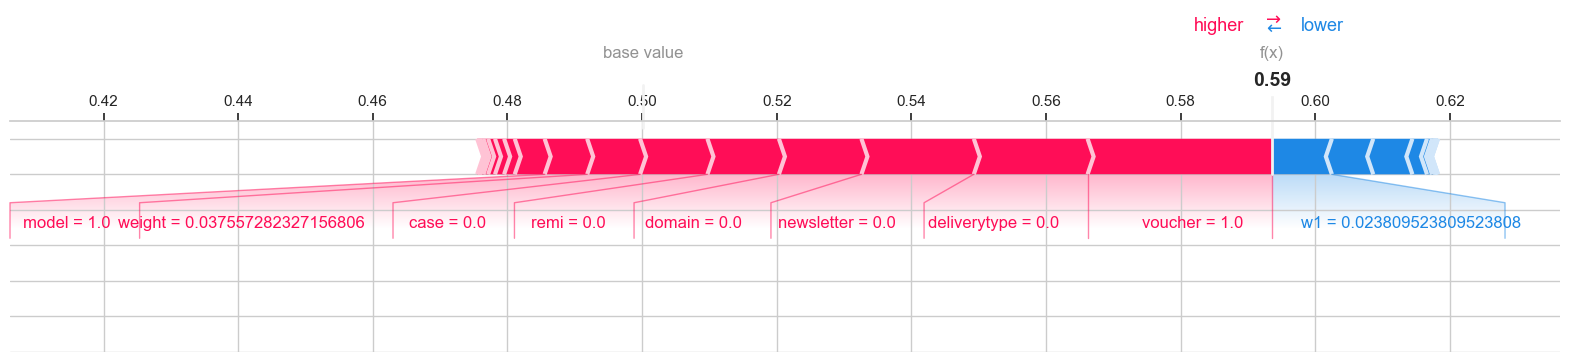

In [ ]:
shap.plots.force(shap_explainer.expected_value[0], shap_values[0][0,:], x_test.iloc[0, :], matplotlib = True)

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

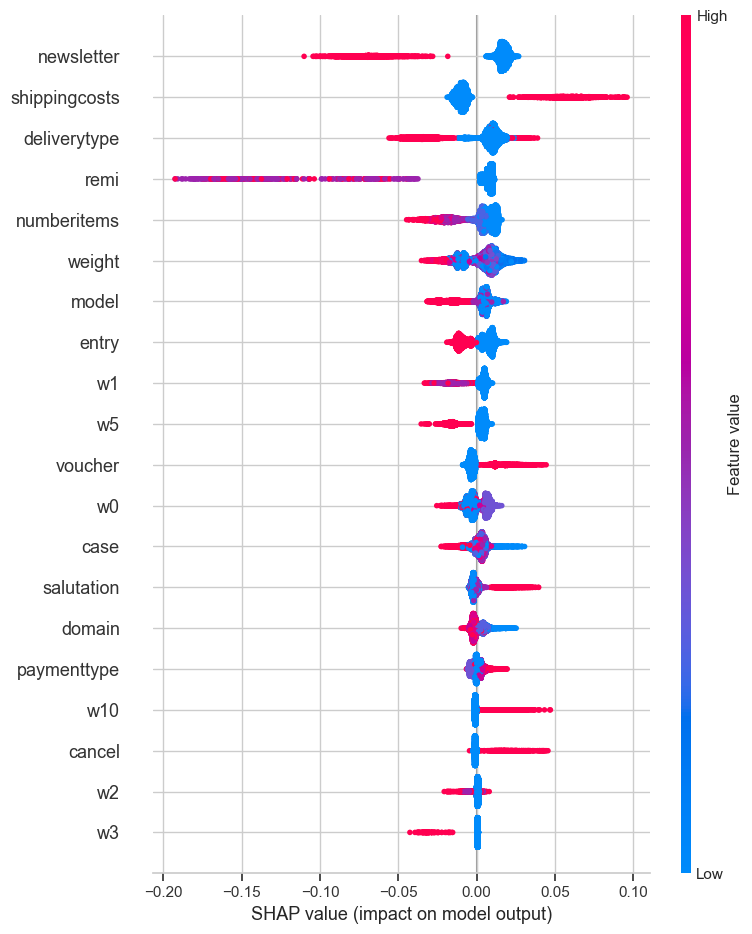

In [ ]:
shap.summary_plot(shap_values[0], x_test)

An increasing number of remitted items, as well as not being subscribed to the newsletter for example has a negative influence on the repurchase probability.